In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DKpp:
    ''' An implementation of the D -> K pi+ pi- decay amplitude,
        following code by S. Schacht.'''

    def __init__(self):
        ''' Load all of the numerical constants and preprocess them for quick access during evalution,'''
        # Some mass and width constants, using PDG 2016 values (in GeV)
        self.m = {'D0'  : 1.86483,
                  'K0'  : 0.497611,
                  'pic' : 0.13957018,
                  'pi0' : 0.1349766,
                  'eta' : 0.547862,
                  'etap': 0.95778}
        self.gam, self.L = {}, {}

        # pi-pi resonances
        self.m['rho770'],   self.gam['rho770'],   self.L['rho770']   = 0.77526, 0.1478,  1
        self.m['omega782'], self.gam['omega782'], self.L['omega782'] = 0.78265, 0.00849, 1
        self.m['f21270'],   self.gam['f21270'],   self.L['f21270']   = 1.2755,  0.1867,  2
        self.m['rho1450'],  self.gam['rho1450'],  self.L['rho1450']  = 1.465,   0.4,     1 #NB: Mass was 1000x too large in S. Schacht code

        # K-pi resonances
        self.m['Ks892'],    self.gam['Ks892'],    self.L['Ks892']    = 0.8937,  0.0472,  1 # Floating fit to data, not PDG value
        self.m['K2s1430'],  self.gam['K2s1430'],  self.L['K2s1430']  = 1.4256,  0.0985,  2
        self.m['Ks1680'],   self.gam['Ks1680'],   self.L['Ks1680']   = 1.717,   0.322,   1
        self.m['Ks1410'],   self.gam['Ks1410'],   self.L['Ks1410']   = 1.414,   0.232,   1 #NB: Mass was 1000x too large in S. Schacht code

        # Needed for seperate L=0 K-pi analysis
        self.m['K0s1430'],  self.gam['K0s1430']                      = 1.441,   0.193

    def M(self):
        ''' Return mass of Dalitz parent (for PS sampling).'''
        return self.m['D0']

    def m1(self):
        ''' Return mass of m1 (for PS sampling).'''
        return self.m['K0']

    def m2(self):
        ''' Return mass of m2 (for PS sampling).'''
        return self.m['pic']

    def m3(self):
        ''' Return mass of m3 (for PS sampling).'''
        return self.m['pic']

    def _pq(self, m12, m1, m2):
        ''' Helper function to compute daughter particle momentum is resonance rest frame.
            The bachelor momentum function is actually exactly the same, except m_1 -> M, m_2 -> m_3
            Written in slightly different form than in summary above for efficent evaluation.'''
        facpp = m12 + m1 + m2
        facmm = m12 - m1 - m2
        facpm = m12 + m1 - m2
        facmp = m12 - m1 + m2

        return 0.5/m12 * np.sqrt(facpp * facmm * facpm * facmp, dtype='complex')

    def _rho(self, s, m1, m2):
        ''' Helper function for computing 2-particle phase-space factors for K-matrix formalism.'''
        return np.sqrt(1 - (m1+m2)**2/s, dtype='complex')

    def _rhoapp(self, s):
        ''' Helper function for computing approximate phase-space matrix for 4 pi state in K-matrix formalism.'''
        return 1.0789*s**6 + 0.1366*s**5 - 0.2974*s**4 - 0.2084*s**3 + 0.1385*s**2 - 0.0193*s + 0.0005

    def sumampresonant(self, sKpm, sKpp, spp, components = False):
        '''The isobar ansatz for non-S-wave resonances.
           Fraction not used in calculation, but comes from after-the-fact fit.'''
        # Resonance model specification, taken from [arXiv:1804.06153], Tables III
        resList = [{'id' : 'rho770',   'Q' : 0,
                    'coeff' : 1,                                       'frac'  : 0.204},  # coefficient fixed
                   {'id' : 'omega782', 'Q' : 0,
                    'coeff' : 0.0388 * np.exp(1j * np.radians(120.7)), 'frac'  : 0.005},
                   {'id' : 'f21270',   'Q' : 0,
                    'coeff' : 1.43 * np.exp(1j * np.radians(-36.3)),   'frac'  : 0.008},
                   {'id' : 'rho1450',  'Q' : 0,
                    'coeff' : 2.85 * np.exp(1j * np.radians(102.1)),   'frac'  : 0.006},
                   {'id' : 'Ks892',    'Q' : -1,
                    'coeff' : 1.720 * np.exp(1j * np.radians(136.8)),  'frac'  : 0.599},
                   {'id' : 'K2s1430',  'Q' : -1,
                    'coeff' : 1.27 * np.exp(1j * np.radians(-44.1)),   'frac'  : 0.013},
                   {'id' : 'Ks1680',   'Q' : -1,
                    'coeff' : 3.31 * np.exp(1j * np.radians(-118.2)),  'frac'  : 0.005},
                   {'id' : 'Ks1410',   'Q' : -1,
                    'coeff' : 0.29 * np.exp(1j * np.radians(99.14)),   'frac'  : 0.001},
                   {'id' : 'Ks892',    'Q' : 1,
                    'coeff' : 0.164 * np.exp(1j * np.radians(-42.2)),  'frac'  : 0.006},
                   {'id' : 'K2s1430',  'Q' : 1,
                    'coeff' : 0.10 * np.exp(1j * np.radians(-89.6)),   'frac'  : 0.00},
                   {'id' : 'Ks1410',   'Q' : 1,
                    'coeff' : 0.21 * np.exp(1j * np.radians(150.2)),   'frac'  : 0.00}]

        # meson radius parameters (in 1/GeV)
        dD, dr = 5.0, 1.5

        if components:
            amp = []
        else:
            amp = np.zeros(len(sKpm), dtype='complex128')

        for res in resList:
            if res['Q'] == 0: #pi-pi resonances
                s = spp.astype(complex)
                p = self._pq(np.sqrt(s), self.m['pic'], self.m['pic'])
                p0 = self._pq(self.m[res['id']], self.m['pic'], self.m['pic'])
                q = self._pq(np.sqrt(s), self.m['D0'], self.m['K0'])
                pq = -0.5*(sKpp - self.m['pic']**2 - self.m['K0']**2 - 2*np.sqrt((self.m['pic']**2 + p**2)*(self.m['K0']**2 + q**2)))
                mD2, mC2 = self.m['D0']**2, self.m['K0']**2
                mB2, mA2 = self.m['pic']**2, self.m['pic']**2
                sAC, sBC = sKpp, sKpm
            elif res['Q'] == 1: #K-pi+ resonances
                s = sKpp.astype(complex)
                p = self._pq(np.sqrt(s), self.m['pic'], self.m['K0'])
                p0 = self._pq(self.m[res['id']], self.m['pic'], self.m['K0'])
                q = self._pq(np.sqrt(s), self.m['D0'], self.m['pic'])
                pq = -0.5*(sKpm - self.m['pic']**2 - self.m['K0']**2 - 2*np.sqrt((self.m['K0']**2 + p**2)*(self.m['pic']**2 + q**2)))
                mD2, mC2 = self.m['D0']**2, self.m['pic']**2
                mB2, mA2 = self.m['K0']**2, self.m['pic']**2
                sAC, sBC = spp, sKpm
            elif res['Q'] == -1: #K-pi- responances
                s = sKpm.astype(complex)
                p = self._pq(np.sqrt(s), self.m['pic'], self.m['K0'])
                p0 = self._pq(self.m[res['id']], self.m['pic'], self.m['K0'])
                q = self._pq(np.sqrt(s), self.m['D0'], self.m['pic'])
                pq = -0.5*(sKpp - self.m['pic']**2 - self.m['K0']**2 - 2*np.sqrt((self.m['K0']**2 + p**2)*(self.m['pic']**2 + q**2)))
                mD2, mC2 = self.m['D0']**2, self.m['pic']**2
                mB2, mA2 = self.m['K0']**2, self.m['pic']**2
                sAC, sBC = spp, sKpp

            # Compute Blatt-Weisskopf barrier penetration factors and Zemach factors for the resonance
            z0, z = (p0*dr)**2, (p*dr)**2 #NB: factors were incorrectly p0*dr, p*dr in S. Schacht code
            if self.L[res['id']] == 1:
                Fr = np.sqrt( (1+z0)/(1+z) )
                Gamma = self.gam[res['id']] * (p/p0)**3 * self.m[res['id']]/np.sqrt(s) * Fr**2
                ZL = sAC - sBC + (mD2-mC2)*(mB2-mA2)/s #-2*pq
                #print('CLEO form: {}, Laura++ form: {}'.format(ZL, -4*pq))
            elif self.L[res['id']] == 2:
                Fr = np.sqrt( ((z0-3)**2+9*z0)/((z-3)**2+9*z) )
                Gamma = self.gam[res['id']] * (p/p0)**5 * self.m[res['id']]/np.sqrt(s) * Fr**2
                ZL = (sAC - sBC + (mD2-mC2)*(mB2-mA2)/s)**2 - 1/3 * (s - 2*(mD2+mC2) + (mD2-mC2)**2/s)*(s - 2*(mA2+mB2) + (mA2-mB2)**2/s) # 4/3 * (3*pq**2 - (p*q)**2)
                #print('CLEO form: {}, Laura++ form: {}'.format(ZL, 16/3 * (3*pq**2 - (p*q)**2)))

            # Compute propagator term for the resonance
            Tr = 1/(self.m[res['id']]**2 - s - 1j * self.m[res['id']] * Gamma)

            fullterm = res['coeff'] * Fr * ZL *  Tr
            if components:
                amp.append(fullterm)
            else:
                amp += fullterm

        return amp

    def F1(self, spp):
        '''The K-matrix model for pi-pi S-wave resonances.'''
        # Some parameterization constants, taken from [arXiv:1804.06153], Tables II & III
        # Represent couplings between pi-pi, K-K, 4pi, eta-eta, and eta-eta' channels
        mPoleKmat = np.array([0.65100, 1.20360, 1.55817, 1.21000, 1.82206])
        gKmat = np.array([[0.22889, -0.55377,  0.00000, -0.39899, -0.34639],
                          [0.94128,  0.55095,  0.00000,  0.39065,  0.31503],
                          [0.36856,  0.23888,  0.55639,  0.18340,  0.18681],
                          [0.33650,  0.40907,  0.85679,  0.19906, -0.00984],
                          [0.18171, -0.17558, -0.79658, -0.00355,  0.22358]])
        fscatt = np.array([0.23399, 0.15044, -0.20545, 0.32825, 0.35412])
        s0scatt, sA0, sA = -3.92637, -0.15, 1.

        # Only 4 entries because production of eta-eta' channel in D decays not kinematically possible (I think)
        beta = np.array([8.5 * np.exp(1j * np.radians(68.5)), 12.2 * np.exp(1j * np.radians(24.0)),
                         29.2 * np.exp(1j * np.radians(-0.1)), 10.8 * np.exp(1j * np.radians(-51.9))])
        fprod = np.array([8.0 * np.exp(1j * np.radians(-126.0)), 26.3 * np.exp(1j * np.radians(-152.3)),
                          33.0 * np.exp(1j * np.radians(-93.2)), 26.2 * np.exp(1j * np.radians(-121.4)),0])
        s0prod = -0.07 # fixed as a reference point

        fA0 = (1 - sA0)/(spp - sA0) * (spp - sA * 0.5 * self.m['pic']**2)

        # Create production vector P
        P = fprod.reshape(1,-1) * ((1 - s0prod)/(spp - s0prod)).reshape(-1,1) # add dummy dimensions for broadcasting
        for i, bfac in enumerate(beta):
            P += bfac * gKmat[i].reshape(1,-1)/(mPoleKmat[i]**2 - spp.reshape(-1,1))

        # Create the K matrix
        fmat = np.zeros((5,5), dtype='complex128')
        fmat[0,:] = fscatt

        K = fmat[np.newaxis, :] * ((1 - s0scatt)/(spp - s0scatt) * fA0)[:, np.newaxis, np.newaxis]
        for i, m in enumerate(mPoleKmat):
            K += np.outer(gKmat[i],gKmat[i])[np.newaxis, :] * (fA0/(m**2 - spp))[:, np.newaxis, np.newaxis]

        # Create phase-space matrix, phase space functions taken from [arXiv:1711.09854]
        rho = np.zeros((len(spp),5,5), dtype='complex128')
        rho[:,0,0] = self._rho(spp, self.m['pic'], self.m['pic'])
        rho[:,1,1] = self._rho(spp, self.m['K0'], self.m['K0'])
        rho[:,2,2] = np.where(spp < 1, self._rhoapp(spp), self._rho(spp, 2*self.m['pic'], 2*self.m['pic']))
        rho[:,3,3] = self._rho(spp, self.m['eta'], self.m['eta'])
        rho[:,4,4] = self._rho(spp, self.m['eta'], self.m['etap'])

        # Put everything together

        result = np.squeeze(np.linalg.inv(np.eye(5)[np.newaxis, :] - 1j * K @ rho) @ P[np.newaxis, :, :, np.newaxis], axis=(0,3))

        return result[:,0] # Take the pi-pi component

    def KpiSwaveamp(self, sKp):
        '''The LASS parameterization for K-pi S-wave resonances,'''
        # Some parameterization constants, taken from [arXiv:1804.06153], Table III
        F, R = 0.96, 1                                   # R is fixed as reference point
        phiF, phiR = np.radians(0.1), np.radians(-109.7)
        a, r = 0.113, -33.8                              # scattering length/effective range

        # Spectator momentum in resonance rest frame
        q = self._pq(np.sqrt(sKp), self.m['pic'], self.m['K0'])       # FIXME: I suspect this is wrong and needs to use D & pi masses (p <> q issue)
        q0 = self._pq(self.m['K0s1430'], self.m['pic'], self.m['K0']) # FIXME: Ditto
        Gamma = self.gam['K0s1430'] * (q/q0) * self.m['K0s1430']/np.sqrt(sKp)

        deltaR = phiR + np.arctan(self.m['K0s1430']*Gamma/(self.m['K0s1430']**2 - sKp))
        #deltaF = phiF + np.arctan2(1, 1/(a*q) + (r*q)/2)              # Rewriting of arccot via 2-argument arctan
        deltaF = phiF + np.arctan(2*a*q/(2+a*q**2*r))              # Rewriting of arccot via arctan

        amp = R * np.sin(deltaR) * np.exp(1j*deltaR) * np.exp(2j*deltaF) + F * np.sin(deltaF) * np.exp(1j*deltaF)

        return amp


    def full(self,DalitzList):
        s12 = DalitzList[:, 0]
        s13 = DalitzList[:, 1]
        s23 = self.m['D0']**2 + self.m['K0']**2 + 2*self.m['pic']**2 - s12 - s13 # cf. [arXiv:1711.09854], eq. 1

        # The coefficients of the K-pi S-wave ampltitudes are missing from [arXiv:1804.06153] equations,
        # but present in the fit tables, so hopefully my guess at the form is correct.
        amp = self.sumampresonant(s13, s12, s23) + self.F1(s23) \
              + 2.36 * np.exp(1j * np.radians(99.4)) * self.KpiSwaveamp(s13) \
              + 0.11 * np.exp(1j * np.radians(162.3)) * self.KpiSwaveamp(s12)

        return amp

    def decomp(self, DalitzList):
        amp = self.full(DalitzList)

        mag2 = np.abs(amp)**2
        phase = np.angle(amp)

        return (mag2, phase)

class BKpp(DKpp):
    ''' An implementation of the B -> (K pi+ pi-) K decay amplitudes.'''

    def __init__(self, rB = 0.0994, deltaB = None, gamma = None, Bcharge=+1): # Central values taken from HFLAV 2022 world averages
        ''' Load all standard D amplitude funcitonality, along with B -> DK parameters.'''
        if deltaB == None:
            deltaB = np.radians(127.7)
        if gamma == None:
            gamma = np.radians(65.9)

        super().__init__()

        self.rB = rB
        self.deltaB = deltaB
        self.gamma = gamma
        self.Bcharge = Bcharge

    def fullBp(self, DalitzList):
        ''' Amplitude for B+ decays.'''
        amp = super().full(DalitzList) + self.rB * np.exp(1j*(self.deltaB + self.gamma)) * super().full(DalitzList[:,::-1])

        return amp

    def fullBm(self, DalitzList):
        ''' Amplitude for B- decays.'''
        amp = super().full(DalitzList[:,::-1]) + self.rB * np.exp(1j*(self.deltaB - self.gamma)) * super().full(DalitzList)

        return amp

    def full(self, DalitzList):
        ''' Compatability with AmpSample.'''
        if self.Bcharge == +1:
            return self.fullBp(DalitzList)
        if self.Bcharge == -1:
            return self.fullBm(DalitzList)

class DalitzSample:
    ''' A class for efficient uniform sampling of the Dalitz plane. '''

    def __init__(self, amp):
        ''' Initialize all Dalitz plane information.
            NB: requires amplitude to be able to provide mother and daughter particle masses.'''
        self.M = amp.M()
        self.m1, self.m2, self.m3 = amp.m1(), amp.m2(), amp.m3()

    def generate(self, nsamples):
        ''' Generate kinematically allowed points uniformly in the s12-s13 plane.'''
        finalpoints = np.zeros((nsamples,2))

        samplesleft = nsamples

        # generate samples with rejection of unphysical points until full result is filled
        while samplesleft > 0:
            points = np.random.rand(samplesleft, 2)

            points[:,0] = ((self.M - self.m3)**2 - (self.m1 + self.m2)**2)*points[:,0] + (self.m1 + self.m2)**2 #s12
            points[:,1] = ((self.M - self.m2)**2 - (self.m1 + self.m3)**2)*points[:,1] + (self.m1 + self.m3)**2 #s13

            # Check if points are kinematically valid (from PDG kinematics review)
            E1star2 = (points[:,0] - self.m2**2 + self.m1**2)**2/(4*points[:,0])
            E3star2 = (self.M**2 - points[:,0] - self.m3**2)**2/(4*points[:,0])
            E1E3star = (points[:,0] - self.m2**2 + self.m1**2)*(self.M**2 - points[:,0] - self.m3**2)/(4*points[:,0])

            s13max = (E1star2 + 2*E1E3star + E3star2) - (np.sqrt(E1star2 - self.m1**2) - np.sqrt(E3star2 - self.m3**2))**2
            s13min = (E1star2 + 2*E1E3star + E3star2) - (np.sqrt(E1star2 - self.m1**2) + np.sqrt(E3star2 - self.m3**2))**2

            validpoints = points[(points[:,1] < s13max) & (points[:,1] > s13min)]

            first = nsamples-samplesleft
            finalpoints[first:first+len(validpoints),:] = validpoints
            samplesleft -= len(validpoints)

        return finalpoints

class AmpSample(DalitzSample):
    ''' A class to produce weighted and unweighted Dalitz plane events. '''

    def __init__(self, amp):
        self.amp = amp
        self.ps = DalitzSample(amp)

        # Mainly for plotting purposes
        self.M = amp.M()
        self.m1, self.m2, self.m3 = amp.m1(), amp.m2(), amp.m3()

    def generate_weighted(self, nsamples):
        ''' Generate weighted samples.
            This is just flat PS sampling with |amp|^2 weights appended.'''

        points = self.ps.generate(nsamples)

        amplitudes  = self.amp.full(points)
        weights = amplitudes.real**2 + amplitudes.imag**2 # About x10 faster than computing |amp|^2
        #phases = np.arctan( amplitudes.imag / amplitudes.real)
        #phases[phases < 0] += 2*np.pi

        #return points, weights, phases
        return points, weights

    def generate(self, nsamples, nbatch=5000):
        ''' Generate unweighted samples.
            This keeps generating test points in batches of nbatch until enough
            events have been produced. Not very efficient, but good enough for the job. '''

        # Initialize bookkeeping
        npass = 0
        maxweight = 0.
        pointList = []
        weightList = []
        acceptList = []

        while npass < nsamples:
            # Generate points & weights
            pointList.append(self.ps.generate(nbatch))
            amplitude = self.amp.full(pointList[-1])
            weightList.append(amplitude.real**2 + amplitude.imag**2)

            # Check if maximum weight needs to be updated
            if weightList[-1].max() > maxweight:
                maxweight = weightList[-1].max()
                for i, weights in enumerate(weightList[:-1]):
                    acceptList[i] = (np.random.rand(nbatch) < weights/maxweight)

            acceptList.append(np.random.rand(nbatch) < weightList[-1]/maxweight)

            npass = sum([accept.sum() for accept in acceptList])

        # Package final accepted points together
        finalpoints = np.concatenate([points[accept] for accept, points in zip(acceptList, pointList)])

        return finalpoints[:nsamples,:]

class CorrSample:
    ''' Class for generating correlated D decays at charm factories '''
    def __init__(self, amp):
        self.amp = amp
        self.ps = DalitzSample(amp)

        # Mainly for plotting purposes
        self.M = amp.M()
        self.m1, self.m2, self.m3 = amp.m1(), amp.m2(), amp.m3()

    def generate_weighted(self, nsamples):
        ''' Generate weighted samples.
            This is just flat PS sampling with |amp|^2 weights appended.'''

        points = self.ps.generate(nsamples)

        amplitudes  = self.amp.full(points)
        weights = amplitudes.real**2 + amplitudes.imag**2 # About x10 faster than computing |amp|^2

        return points, weights

In [4]:
# Initialize sampler
Sampler = AmpSample(DKpp())

print(Sampler.M)
print(Sampler.m1)
print(Sampler.m2)
print(Sampler.m3)

1.86483
0.497611
0.13957018
0.13957018


In [2]:
Sampler = AmpSample(DKpp())

totalpoints = 10000000

points = Sampler.generate(totalpoints, nbatch=50000)
s12, s13 = points[:,0], points[:,1]
s23 = (Sampler.M**2 + Sampler.m1**2 + Sampler.m2**2 + Sampler.m3**2) - s12 - s13

NameError: name 'plt' is not defined

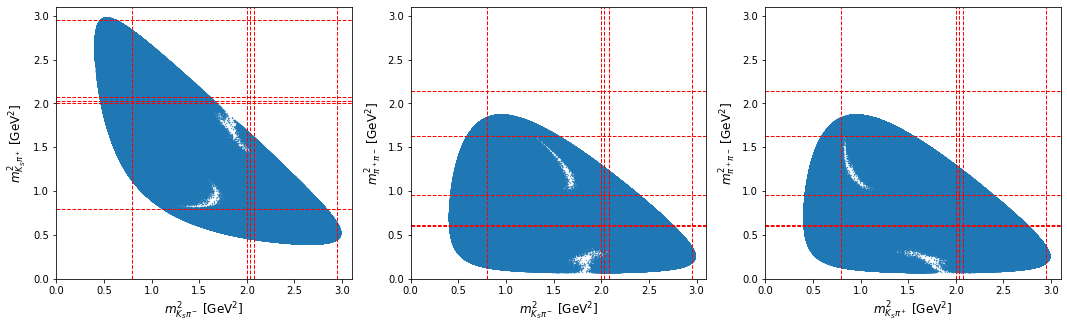

In [5]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(x=s13, y=s12, s=0.1)
plt.xlabel(r'$m_{K_S \pi^-}^2$ [GeV$^2$]', fontsize=12)
plt.ylabel(r'$m_{K_S \pi^+}^2$ [GeV$^2$]', fontsize=12)
plt.xlim(0,3.1)
plt.ylim(0,3.1)

plt.axhline(y = Sampler.amp.m['Ks892']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['Ks1410']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['K0s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['K2s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['Ks1680']**2, c = 'r', ls = '--', lw = 1)

plt.axvline(x = Sampler.amp.m['Ks892']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1410']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K0s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K2s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1680']**2, c = 'r', ls = '--', lw = 1)

plt.subplot(1,3,2)
plt.scatter(x=s13, y=s23, s=0.1)
plt.xlabel(r'$m_{K_S \pi^-}^2$ [GeV$^2$]', fontsize=12)
plt.ylabel(r'$m_{\pi^+\pi^-}^2$ [GeV$^2$]', fontsize=12)
plt.xlim(0,3.1)
plt.ylim(0,3.1)

plt.axhline(y = Sampler.amp.m['rho770']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['omega782']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = 0.980**2, c = 'r', ls = '--', lw = 1) #f0(980)
plt.axhline(y = Sampler.amp.m['f21270']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['rho1450']**2, c = 'r', ls = '--', lw = 1)

plt.axvline(x = Sampler.amp.m['Ks892']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1410']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K0s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K2s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1680']**2, c = 'r', ls = '--', lw = 1)

plt.subplot(1,3,3)
plt.scatter(x=s12, y=s23, s=0.1)
plt.xlabel(r'$m_{K_S \pi^+}^2$ [GeV$^2$]', fontsize=12)
plt.ylabel(r'$m_{\pi^+\pi^-}^2$ [GeV$^2$]', fontsize=12)
plt.xlim(0,3.1)
plt.ylim(0,3.1)

plt.axhline(y = Sampler.amp.m['rho770']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['omega782']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = 0.980**2, c = 'r', ls = '--', lw = 1) #f0(980)
plt.axhline(y = Sampler.amp.m['f21270']**2, c = 'r', ls = '--', lw = 1)
plt.axhline(y = Sampler.amp.m['rho1450']**2, c = 'r', ls = '--', lw = 1)

plt.axvline(x = Sampler.amp.m['Ks892']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1410']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K0s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['K2s1430']**2, c = 'r', ls = '--', lw = 1)
plt.axvline(x = Sampler.amp.m['Ks1680']**2, c = 'r', ls = '--', lw = 1)

plt.show()

In [6]:
print(points.shape)

(10000000, 2)


In [8]:
print(s12[0])
print(s13[0])
print(s23[0])

2.81923025404648
0.5898898209331864
0.3550472315317983


In [9]:
s12s13s23 = np.array([np.array([s12[i], s13[i], s23[i]]) for i in range(totalpoints)])

In [10]:
print(s12s13s23[0])

[2.81923025 0.58988982 0.35504723]


In [11]:
np.save('B_Kspipi_amp_1e7.npy', s12s13s23)